# Create and inspect a detector response for one burst

A detector response matrix codifies two sets of quantities:

1. The effective area as a function of energy. That is, the equivalent collection area a perfect detector would have that will result in the same number of counts for a given flux.
2. The probability of a photon of energy $E$ to be assigned to a channel energy $E'$

These allow us to reconstruct physical quantities —e.g. spectrum and localization— out of simple counts.

The detector response matrix is then a 2D matrix of "real" photon energy versus assigned channel energy. Each entry is the effective area of the corresponding photon energy bin, times the fraction of events in the photon energy bin that land in the corresponding channel energy.

This matrix is generated based on particle-by-particle simulations using the app `bc-rsp`. The basic usage is

```bash
$ bc-rsp config_file working_dir --ntriggers NTRIGGERS --direction ZENITH AZIMUTH
```

You can see other optional arguments by using the `--help` flag or by looking at the "Scripts" documentation.

The `config_file` argument is the path to the YAML configuration file. An example is provided with this library. You can find the path to it either using the following command line executable:

```bash
$ bc-config-example-path 
```

or using the API:

In [1]:
import bctools.config

bctools.config.config_file_example

PosixPath('/Users/imartin5/burstcube/software/bc-tools/bctools/config/bc_config.yaml')

`bc-rsp` uses the parameters in the `simulations` and `detector` section of the config file. 
Worth mentioning are the parameters from `simulations:detector_effects`. These codify the results from calibration and indicates how to simulate effects from a realistic detector, such as energy resolution and efficiency.

The final output of `bc-rsp` is a detector response matrix (DRM) file. There are also complementary files with the suffix `_peak.h5`, which corresponds to the detector response including only events from the photopeak, that is, those photons which deposited all of their energy in a given detector.

To load the DRM for a given detector --`CS0` in this case-- do

In [6]:
from bctools.sims import DRM, DRMList

# Test data
import bctools.data as data

# Response from zenith (the axis of the whole instrument, not a single detector)
drm_list = DRMList.open(data.path / "sims/drm_zenith.h5")
drm_peak_list = DRMList.open(data.path / "sims/drm_zenith_peak.h5")

In [7]:
drm_list.detectors

('CS0', 'CS1', 'CS2', 'CS3')

In [9]:
drm = drm_list['CS0']

/Users/imartin5/burstcube/software/bc-tools/bctools/sims/drm.py:307: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(self.energy_channels.lo_lim.value,


(10.0, 5000.0)

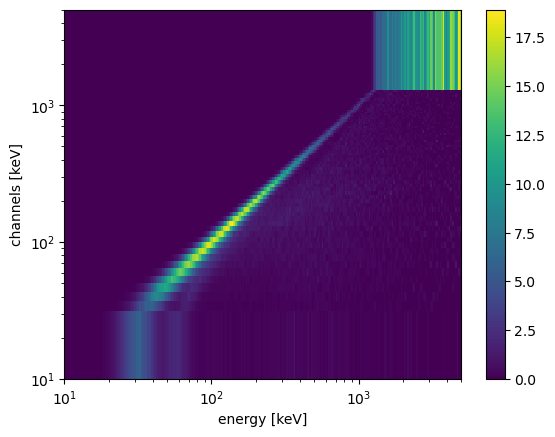

In [10]:
ax,plot = drm.plot()

ax.set_ylim(drm.photon_energies.lo_lim.value,drm.photon_energies.hi_lim.value)

In [11]:
import astropy.units as u

drm.effective_area([100,200]*u.keV)

TypeError: 'Quantity' object with a scalar value is not iterable

In [22]:
drm.axes.labels

array(['energy', 'channels'], dtype='<U8')

In [23]:
drm.project('energy')

AttributeError: 'DRM' object has no attribute 'project'

(30, 1200)

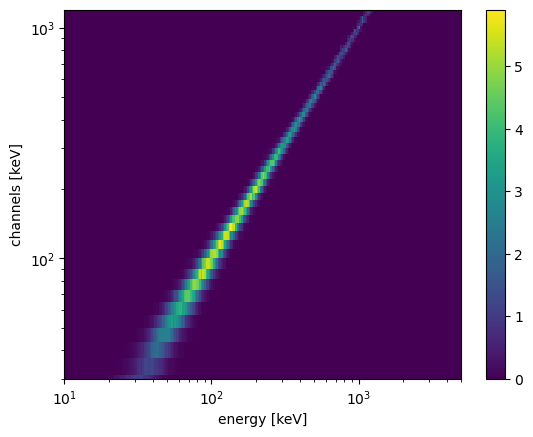

In [7]:
ax,plot = drm_peak.plot()

ax.set_ylim(30,1200)

You can transform this objecto to an RSP FITS files, as used by GBM and other instruments:

In [4]:
from bctools.config import set_config
from yayc import Configurator

set_config(Configurator.open(bctools.config.config_file_example))

drm.to_gbm_rsp()

KeyError: "Parameter 'io:headers:RSP' doesn't exists"

you can then plot it

In [ ]:
from gbm.plot import ResponseMatrix

rsp_plot = ResponseMatrix()
rsp_plot.set_response(rsp, color="plasma")

The projection onto the x-axis is the effective area

In [ ]:
from gbm.plot import PhotonEffectiveArea

import matplotlib.pyplot as plt

fig,ax = plt.subplots(dpi=150)

effarea_energy = PhotonEffectiveArea(data=rsp, axis=ax)
effarea_energy._data.color = 'orange' #Workaround

effarea_energy_peak = PhotonEffectiveArea(data=rsp_peak, axis=ax)

ax.legend([effarea_energy._data._artists[0],effarea_energy_peak._data._artists[0]],["Total", "Photopeak"]); #Workaround

This is the typical reponse for a gamma-ray detector using scintillator, such as BurstCube, GBM or BATSE. At low energies there is a cutoff since the photons are not energetic enough to reach the scintillator and get a measurement. At high energies, pair-production dominates the total effective area. Although the gamma-rays do interact with the detector and produce a count, only a small fraction of the energiy is deposited. This cutoff can be seen in photopeak response, where we only considered those events that were fully absorbed due to either the photoelectric effect or in combination with other effects such as Compton scattering. 

Having the full detector response allows us to account for the energy resolution and contamination by these partially-absorbed events. In practice, GRBs and other sources typically have a falling spectrum with an index of $\gtrsim -1.5$, so simulating up to ~10 MeV is sufficient.

You can also open an  `.rsp` file directly using the `bc-tools` library:

In [ ]:
from bctools.sims import DRM
    
drm = DRM.from_gbm_rsp_file(data.path / "sims/SQD0_zenith.rsp")

In [ ]:
import matplotlib.pyplot as plt

Note that you can go back and forth between GBM's RSP and the native DRM with `DRM.from_rsp()` and `DRM.to_rsp()`.

As an example on how to use a DRM let's plot the expected measured counts per second from a monoenergetic source. Say our source is $^{137}$Cs (peak energy at 662 keV), has an activity of 1 $\mu$Ci and is located at 1 m from the center of the detector.

In [ ]:
# We used the BurstCube's units module to keep track of units. 
# These are just constants, with the value of 1 assigned to base units (keV, s, cm). 
from bctools.util import units as u

energy = 662 * u.keV
activity = 3.7e4 / u.s # 1 uCi
distance = 1 * u.meter
flux = activity / (4*u.pi*distance**2) # Photons per area

# drm.energy_channels gives you an Axis object describing the binning of the energy channels
# from which you can get the centers, edges, lower_bounds, upper_bounds, or the number of channels (nbins)
energy_channels = drm.energy_channels

# We can get the total expected counts using:
tot_rate = flux * drm.effective_area(energy)

print("Total rate = {:.2} Hz".format(tot_rate * u.s))

# However, due to a finite energy resolution and other instrumental effects, there is an energy spread
channel_rate = flux * drm.channel_effective_area(energy, range(energy_channels.nbins))

# Plot it
fig,ax = plt.subplots(dpi=150)

ax.plot(energy_channels.lower_bounds,
        channel_rate,
        drawstyle = 'steps-post')

ax.set_xscale('log')

ax.set_ylabel("Expected count rates [Hz]")
ax.set_xlabel("Channel energy [MeV]");

In this case we assumed that the source is sufficiently far away to model it with a detector response with a source at infinity (the default). Furthermore, this assumes that there are no nearby sources of scattering or attenuation. An improvement of this would be to generate a detector response with the command line option `--distance` in `bc-rsp`. This would mimic more accurately, for example, what happens during calibration.